# Configuración e importación de librerías



In [11]:
from google.colab import drive
drive.mount('/content/drive')
#drive.mount("/content/drive", force_remount=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Mounted at /content/drive


In [9]:
#!pip install --upgrade pip setuptools

In [10]:
#!pip install --upgrade imagecodecs
#!pip install --upgrade opencv-contrib-python

In [12]:
%matplotlib inline
import pandas as pd 
import numpy as np
import os

import matplotlib.pyplot as plt
import tifffile as tiff

import cv2
from google.colab.patches import cv2_imshow

from imutils import contours
from skimage import measure
import imutils

# Localización de ciervos automatizada

In [13]:
def get_file_names(path, file_start):
  return sorted([f for f in os.listdir(path) if f.startswith(file_start)])

In [14]:
path_THM_def = '/content/drive/MyDrive/TFM - Imagenes drones/Imagenes_ciervos_definitivo/ortofotos_recortadas/THM_def/'
east_thm_file_names= get_file_names(path_THM_def, 'T-Este_THM')

path_RGB_def = '/content/drive/MyDrive/TFM - Imagenes drones/Imagenes_ciervos_definitivo/ortofotos_recortadas/RGB_def/'
east_rgb_file_names= get_file_names(path_RGB_def, 'T-este_def')

In [15]:
thm_path='/content/drive/MyDrive/TFM - Imagenes drones/Imagenes_ciervos_definitivo/ortofotos_recortadas/THM_def/'
rgb_path='/content/drive/MyDrive/TFM - Imagenes drones/Imagenes_ciervos_definitivo/ortofotos_recortadas/RGB_def/'
roi_path='/content/drive/My Drive/TFM - Imagenes drones/Imagenes_ciervos_definitivo/Thermal_Cropped_ROI/'

In [ ]:
def load_preprocess_locate_crop(thm_path, thm_file_names, rgb_path, rgb_file_names, roi_path,
                                   GaussianBlurRadius=21, boundingRect_w_limit=10, boundingRect_h_limit=10, boundingRect_k_padding=20):
  total_n_cnt= []
  total_n_brect= []
  df_ROI_pixel_reference=  pd.DataFrame(columns=['path', 'file_name', 'x', 'y', 'w', 'h', 'k'])

  for i, (file_thm, file_rgb) in enumerate(zip(thm_file_names, rgb_file_names)):
    print(i)
    print(file_thm)
    print(file_rgb)
    
    # load and preprocess the thermal image
    image_thermal= cv2.imread(thm_path + file_thm, cv2.IMREAD_UNCHANGED)
    image_thermal= np.where(image_thermal < 0, 0, image_thermal) #only extreme pixels will be impacted
    print("image_thermal min: %d, max: %d, median: %d, mean: %d" %(image_thermal.min(), image_thermal.max(), np.median(image_thermal), image_thermal.mean()))

    # convert to 8-bit format
    image_thermal_scale= cv2.convertScaleAbs(image_thermal)

    # load the optical image
    image_optical= cv2.imread(rgb_path + file_rgb, cv2.IMREAD_UNCHANGED)
    im_op_height, im_op_width, im_op_channel= image_optical.shape
    print("image_optical min: %d, max: %d, median: %d, mean: %d" %(image_optical.min(), image_optical.max(), np.median(image_optical), image_optical.mean()))

    # Apply a Gaussian blur to the thermal image (radius must be an odd number)
    image_thermal_scale = cv2.GaussianBlur(src=image_thermal_scale, ksize=(GaussianBlurRadius, GaussianBlurRadius), sigmaX=0, sigmaY=0)

    # threshold the thermal image to reveal light regions
    threshold= np.mean((np.median(image_thermal), image_thermal.max()))
    print("threshold: %d" %threshold)
    ret, thresh = cv2.threshold(src= image_thermal_scale, thresh= threshold, maxval= 255, type= cv2.THRESH_BINARY)
    tiff.imshow(thresh)

    # find contours
    contours, hierarchy= cv2.findContours(image=thresh, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_SIMPLE)
    n_cnt= len(contours)
    print("Number of countours found before filtering: %d" %n_cnt)
    total_n_cnt.append(n_cnt)

    # Find bounding box, extract ROI, write cropped optical image to file
    n_brect=0
    k=boundingRect_k_padding
    for j, c in enumerate(contours):
      x, y, w, h = cv2.boundingRect(c)
      if w>boundingRect_w_limit and h>boundingRect_h_limit:
        n_brect+= 1
        file_roi= '%s_%d.tif' %(file_rgb.split('.')[0], j)
        #print(j)
        #print("(x,y) rectangle top-left coordinates %d %d" %(x, y))
        #print("(w,h) rectangle width and height %d %d" %(w, h))
        #print("\n")

        # Check if k padding can be applied to image (image cannot be out of bounds)
        if x>=k and y>=k and x+w<=im_op_width-k and y+h<=im_op_height-k:
          ROI = image_optical[y-k:y+h+k, x-k:x+w+k]
          df_ROI_pixel_reference= df_ROI_pixel_reference.append({"path":roi_path, "file_name":file_roi, "x":x, "y":y, "w":w, "h":h, "k":k},
                                                                ignore_index=True)
        else:
          ROI = image_optical[y:y+h, x:x+w]
          df_ROI_pixel_reference= df_ROI_pixel_reference.append({"path":roi_path, "file_name":file_roi, "x":x, "y":y, "w":w, "h":h, "k":0},
                                                                ignore_index=True)

        cv2.imwrite(roi_path + file_roi, ROI)

    print("Number of bounding boxes found: %d" %n_brect)
    total_n_brect.append(n_brect)

  df_ROI_pixel_reference.to_csv(roi_path + 'ROI_pixel_reference.csv', index=False)
  print("Total number of countours before filtering: %d" %sum(total_n_cnt))
  print("Total number of bounding boxes found: %d" %sum(total_n_brect))

  return sum(total_n_cnt), sum(total_n_brect)

0
T-Este_THM-0-0.tif
T-este_def-0-0.tif
image_thermal min: 0, max: 14, median: 10, mean: 6
image_optical min: 0, max: 1, median: 0, mean: 0
threshold: 12
Number of countours found before filtering: 331
Number of bounding boxes found: 140
1
T-Este_THM-0-1.tif
T-este_def-0-1.tif
image_thermal min: 0, max: 15, median: 0, mean: 3
image_optical min: 0, max: 1, median: 1, mean: 0
threshold: 7
Number of countours found before filtering: 121
Number of bounding boxes found: 59
2
T-Este_THM-0-2.tif
T-este_def-0-2.tif
image_thermal min: 0, max: 12, median: 0, mean: 0
image_optical min: 0, max: 1, median: 1, mean: 0
threshold: 6
Number of countours found before filtering: 14
Number of bounding boxes found: 8
3
T-Este_THM-0-3.tif
T-este_def-0-3.tif
image_thermal min: 0, max: 0, median: 0, mean: 0
image_optical min: 1, max: 1, median: 1, mean: 1
threshold: 0
Number of countours found before filtering: 0
Number of bounding boxes found: 0
4
T-Este_THM-0-4.tif
T-este_def-0-4.tif
image_thermal min: 0, m

/usr/local/lib/python3.6/dist-packages/tifffile/tifffile.py:14181: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  facecolor='1.0', edgecolor='w')


Number of countours found before filtering: 0
Number of bounding boxes found: 0
21
T-Este_THM-4-1.tif
T-este_def-4-1.tif
image_thermal min: 0, max: 0, median: 0, mean: 0
image_optical min: 1, max: 1, median: 1, mean: 1
threshold: 0
Number of countours found before filtering: 0
Number of bounding boxes found: 0
22
T-Este_THM-4-2.tif
T-este_def-4-2.tif
image_thermal min: 0, max: 13, median: 0, mean: 0
image_optical min: 0, max: 1, median: 1, mean: 0
threshold: 6
Number of countours found before filtering: 46
Number of bounding boxes found: 25
23
T-Este_THM-4-3.tif
T-este_def-4-3.tif
image_thermal min: 0, max: 17, median: 0, mean: 3
image_optical min: 0, max: 1, median: 1, mean: 0
threshold: 8
Number of countours found before filtering: 394
Number of bounding boxes found: 204
24
T-Este_THM-4-4.tif
T-este_def-4-4.tif
image_thermal min: 0, max: 16, median: 9, mean: 5
image_optical min: 0, max: 1, median: 0, mean: 0
threshold: 13
Number of countours found before filtering: 124
Number of boun

(2638, 1236)

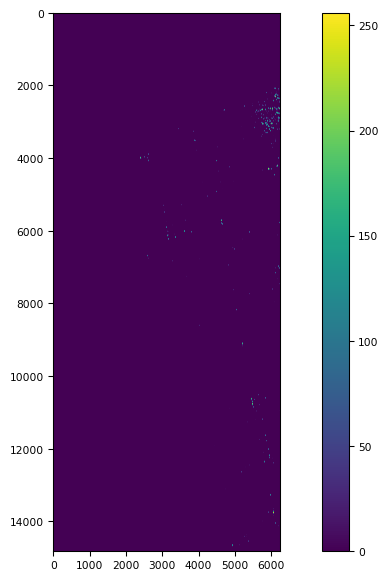

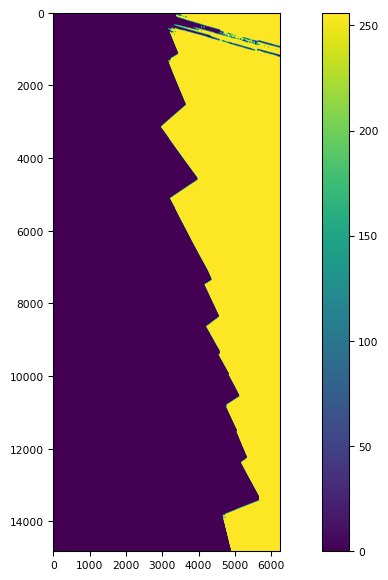

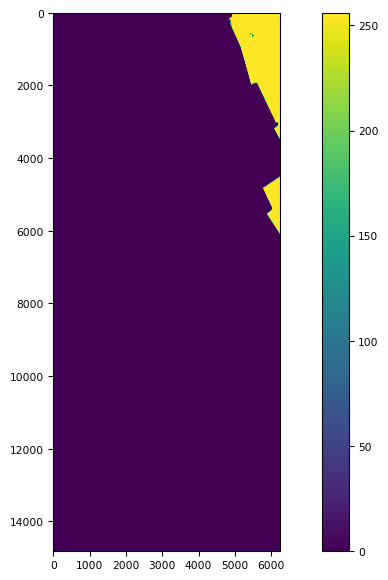

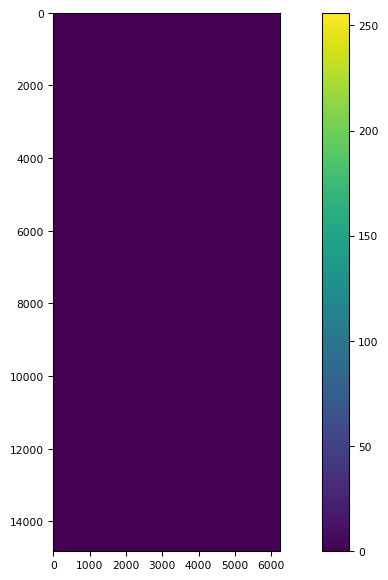

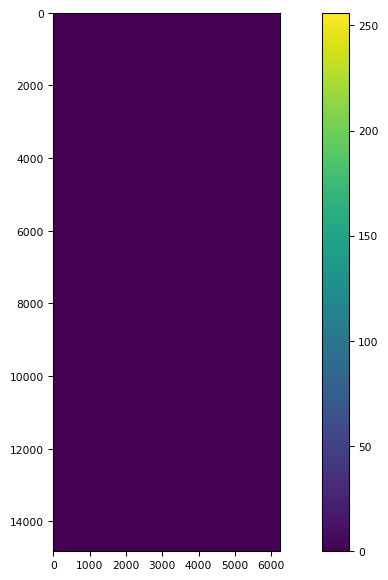

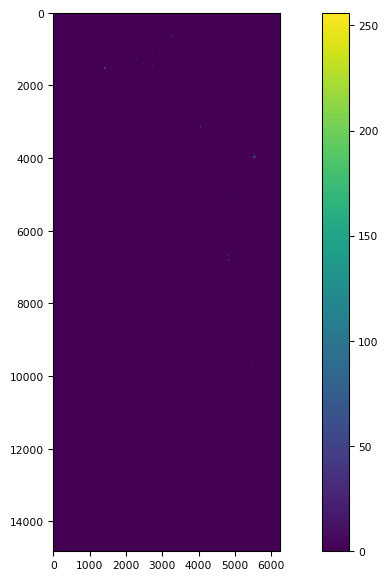

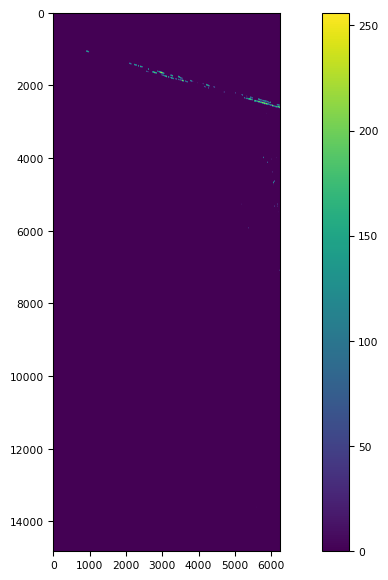

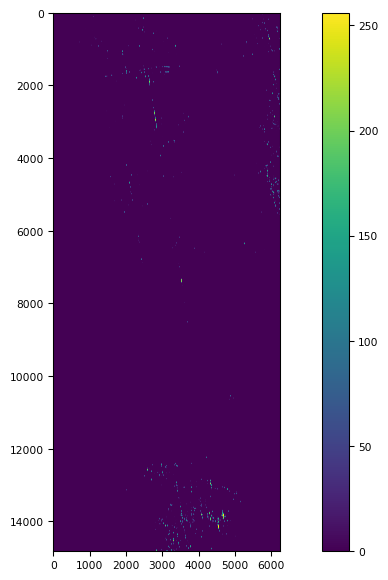

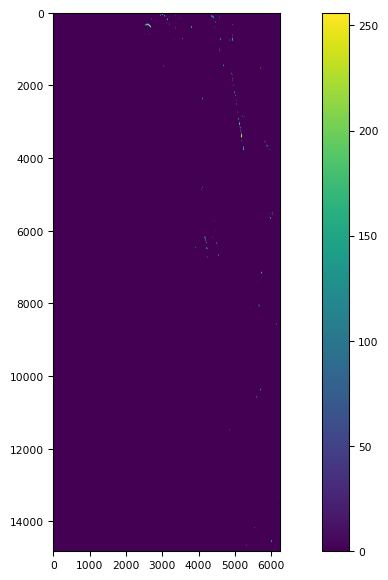

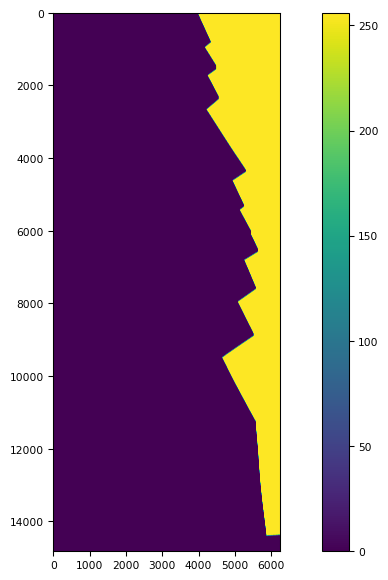

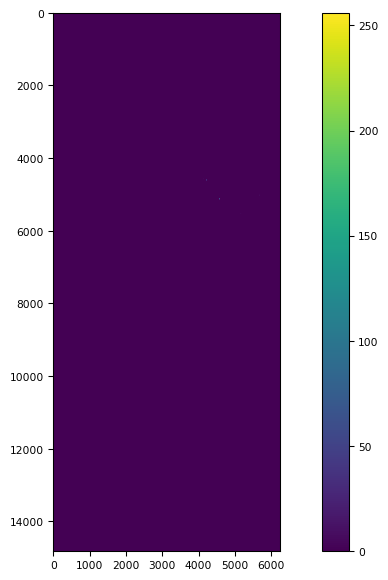

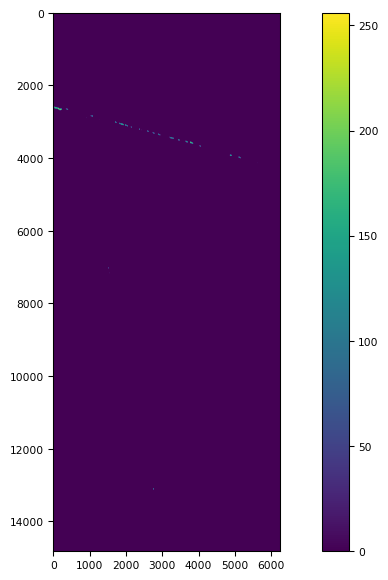

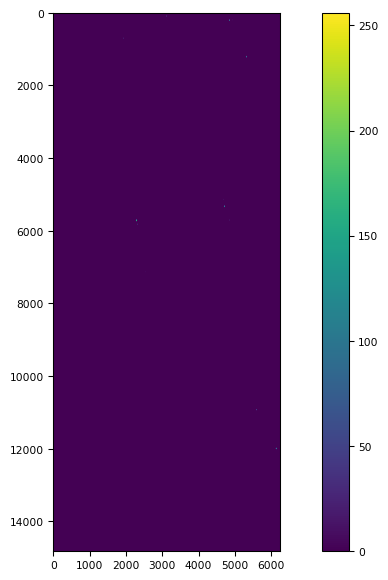

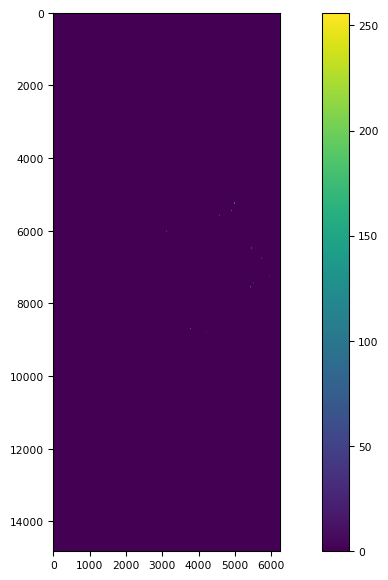

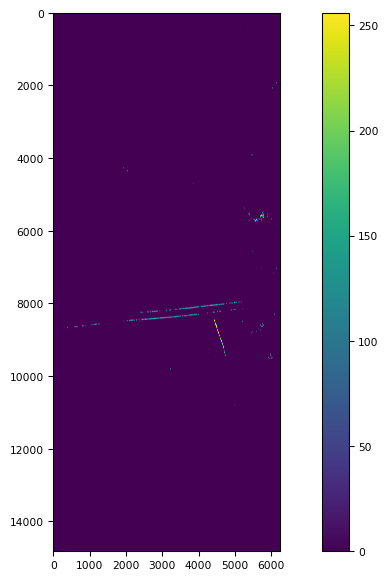

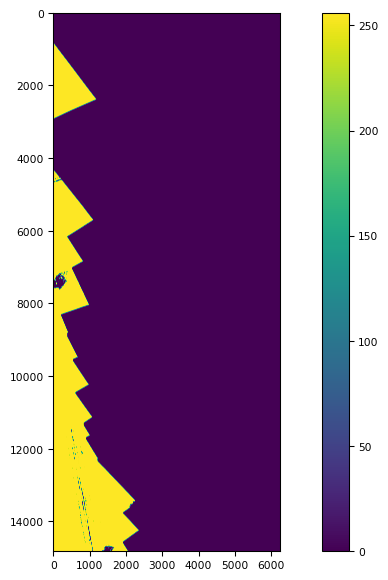

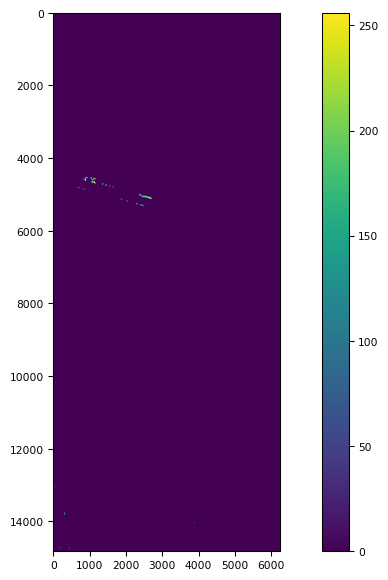

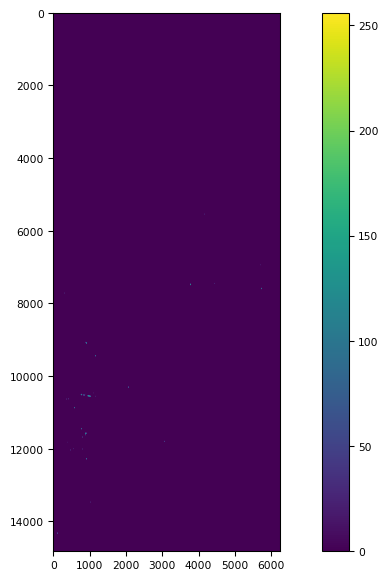

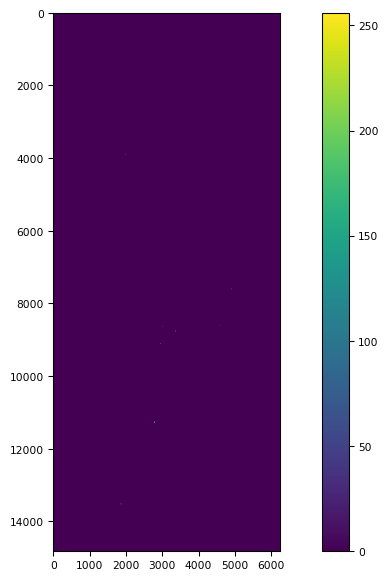

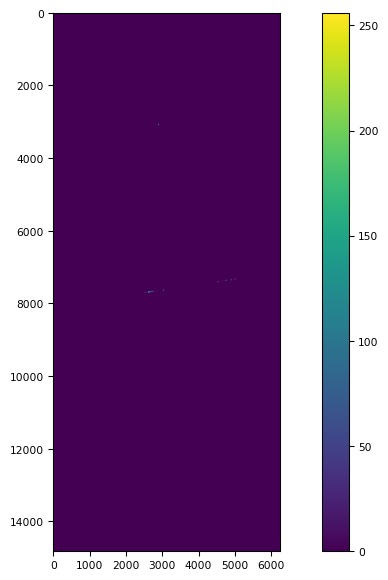

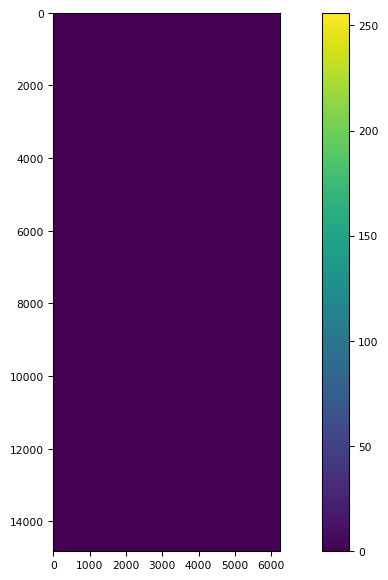

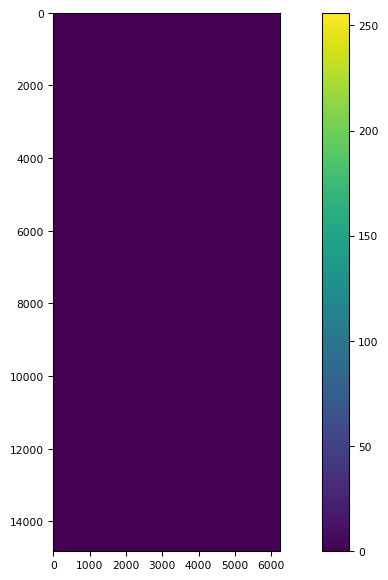

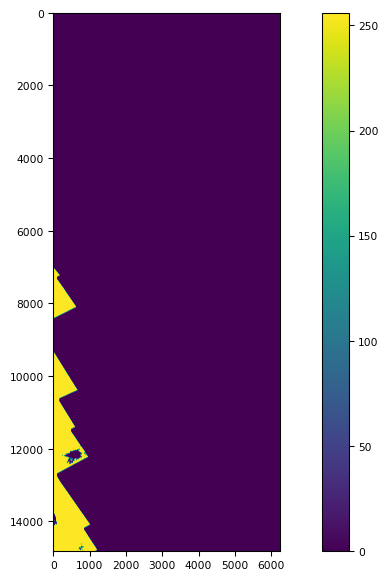

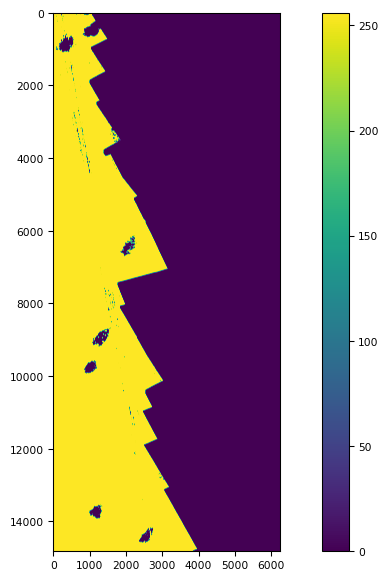

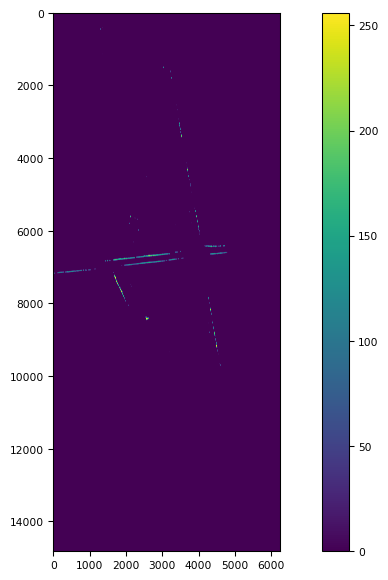

In [ ]:
load_preprocess_locate_crop(thm_path=thm_path, thm_file_names=east_thm_file_names, rgb_path=rgb_path, rgb_file_names=east_rgb_file_names, roi_path=roi_path,
                               GaussianBlurRadius=21, boundingRect_w_limit=10, boundingRect_h_limit=10, boundingRect_k_padding=20)

Examinemos el resultado: observamos que hay gran número de falsos positivos pero también parece que hay positivos positivos

In [ ]:
image_optical_ROI_1 = cv2.imread('/content/drive/My Drive/TFM - Imagenes drones/Imagenes_ciervos_definitivo/Thermal_Cropped_ROI/T-este_def-2-3_1.tif', cv2.IMREAD_UNCHANGED)
image_optical_ROI_2 = cv2.imread('/content/drive/My Drive/TFM - Imagenes drones/Imagenes_ciervos_definitivo/Thermal_Cropped_ROI/T-este_def-2-3_2.tif', cv2.IMREAD_UNCHANGED)
image_optical_ROI_3 = cv2.imread('/content/drive/My Drive/TFM - Imagenes drones/Imagenes_ciervos_definitivo/Thermal_Cropped_ROI/T-este_def-2-3_3.tif', cv2.IMREAD_UNCHANGED)
image_optical_ROI_6 = cv2.imread('/content/drive/My Drive/TFM - Imagenes drones/Imagenes_ciervos_definitivo/Thermal_Cropped_ROI/T-este_def-2-3_6.tif', cv2.IMREAD_UNCHANGED)
image_optical_ROI_7 = cv2.imread('/content/drive/My Drive/TFM - Imagenes drones/Imagenes_ciervos_definitivo/Thermal_Cropped_ROI/T-este_def-2-3_7.tif', cv2.IMREAD_UNCHANGED)
image_optical_ROI_16 = cv2.imread('/content/drive/My Drive/TFM - Imagenes drones/Imagenes_ciervos_definitivo/Thermal_Cropped_ROI/T-este_def-2-3_16.tif', cv2.IMREAD_UNCHANGED)

(<Figure size 988.8x604.8 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7f613a8b2b70>)

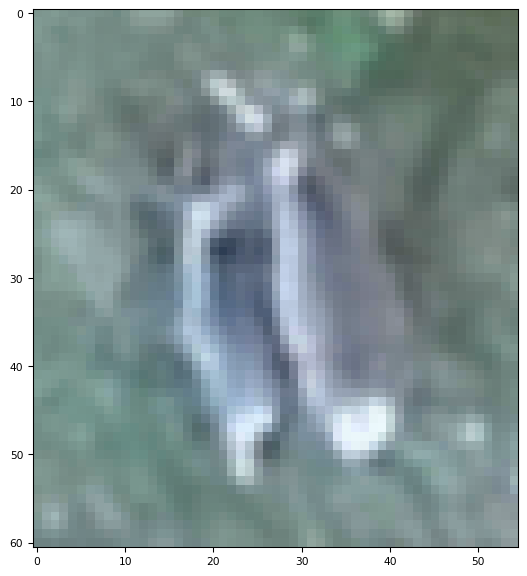

In [ ]:
image_optical_ROI_1.shape
tiff.imshow(image_optical_ROI_1)

(<Figure size 988.8x604.8 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7f613a813cc0>)

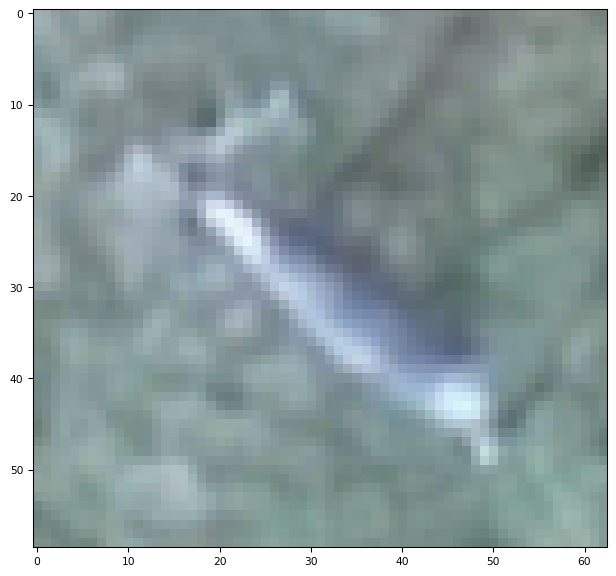

In [ ]:
image_optical_ROI_2.shape
tiff.imshow(image_optical_ROI_2)

(<Figure size 988.8x604.8 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7f613a7f0e80>)

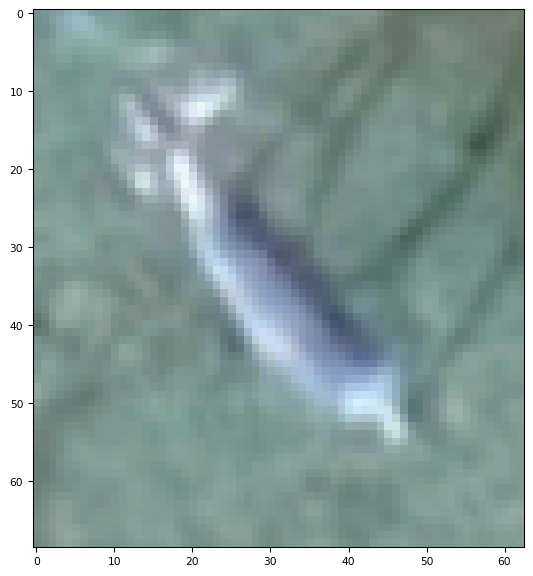

In [ ]:
image_optical_ROI_3.shape
tiff.imshow(image_optical_ROI_3)

(<Figure size 988.8x604.8 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7f613b136ef0>)

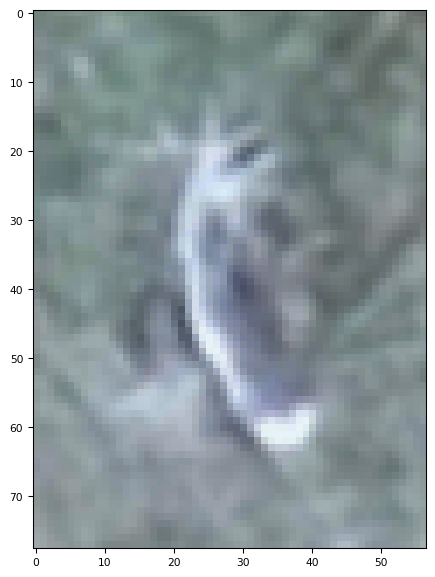

In [ ]:
image_optical_ROI_6.shape
tiff.imshow(image_optical_ROI_6)

(<Figure size 988.8x604.8 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7f613b1c6358>)

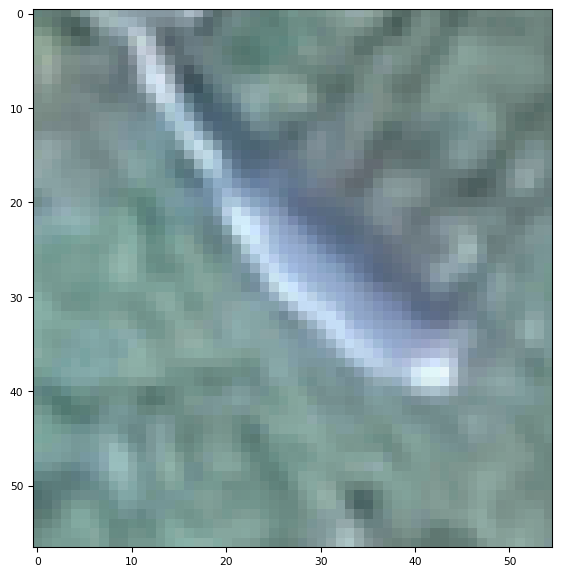

In [ ]:
image_optical_ROI_7.shape
tiff.imshow(image_optical_ROI_7)

(<Figure size 988.8x604.8 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7f613b7c9908>)

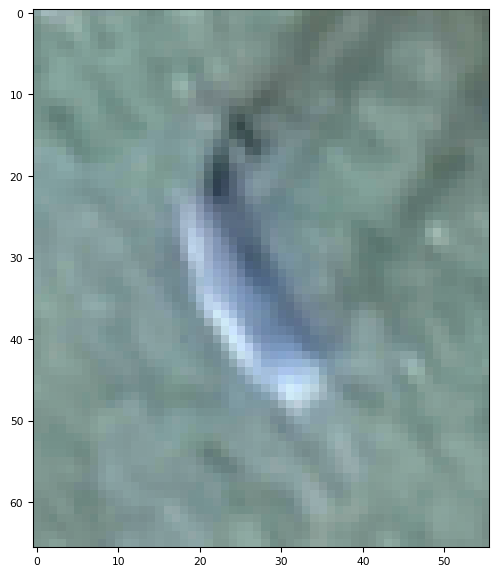

In [ ]:
image_optical_ROI_16.shape
tiff.imshow(image_optical_ROI_16)

# Localización de ciervos automatizada para imágenes térmicas extremas

Threshold calculado utilizando la lógica siguiente: 

Apply different logic to "regular" and "extreme" thermal images, using the distance between the max() and the median() pixel intensity to determine the type of image:
- Regular thermal image: threshold calculated using the average of the median() and the max() pixel intensity
- Extreme thermal image: threshold calculated using a weighted sum that favours the max() pixel intensity over the median() pixel intensity

Extreme thermal images have a very asymetric pixel intensity distribution. To identify them we apply the following criteria: if the distance between the max() and the median() is bigger than (2/3)*max(), the image is identified as "extreme".

In [30]:
def load_preprocess_locate_crop_extreme(thm_path, thm_file_names, rgb_path, rgb_file_names, roi_path,
                                        GaussianBlurRadius=21, boundingRect_w_limit=10, boundingRect_h_limit=10, boundingRect_k_padding=20):
  total_n_cnt= []
  total_n_brect= []
  df_ROI_pixel_reference=  pd.DataFrame(columns=['path', 'file_name', 'x', 'y', 'w', 'h', 'k'])

  for i, (file_thm, file_rgb) in enumerate(zip(thm_file_names, rgb_file_names)):
    print(i)
    print(file_thm)
    print(file_rgb)
    
    # load and preprocess the thermal image
    image_thermal= cv2.imread(thm_path + file_thm, cv2.IMREAD_UNCHANGED)
    image_thermal= np.where(image_thermal < 0, 0, image_thermal) #only extreme pixels will be impacted
    print("image_thermal min: %d, max: %d, median: %d, mean: %d" %(image_thermal.min(), image_thermal.max(), np.median(image_thermal), image_thermal.mean()))

    # convert to 8-bit format
    image_thermal_scale= cv2.convertScaleAbs(image_thermal)

    # load the optical image
    image_optical= cv2.imread(rgb_path + file_rgb, cv2.IMREAD_UNCHANGED)
    im_op_height, im_op_width, im_op_channel= image_optical.shape
    print("image_optical min: %d, max: %d, median: %d, mean: %d" %(image_optical.min(), image_optical.max(), np.median(image_optical), image_optical.mean()))

    # Apply a Gaussian blur to the thermal image (radius must be an odd number)
    image_thermal_scale = cv2.GaussianBlur(src=image_thermal_scale, ksize=(GaussianBlurRadius, GaussianBlurRadius), sigmaX=0, sigmaY=0)

    # threshold the thermal image to reveal light regions
    # Apply different logic to "regular" and "extreme" thermal images, using the distance between the max() and the median() pixel intensity to determine the type of image
    #  - Regular thermal image: threshold calculated using the average of the median() and the max() pixel intensity
    #  - Extreme thermal image: threshold calculated using a weighted sum that favours the max() pixel intensity  
    if image_thermal.max() - np.median(image_thermal) > (2/3) * image_thermal.max():
      threshold= image_thermal.max()*0.80 + np.median(image_thermal)*0.20
    else:
      threshold= np.mean((np.median(image_thermal), image_thermal.max()))
    print("threshold: %d" %threshold)
    ret, thresh = cv2.threshold(src= image_thermal_scale, thresh= threshold, maxval= 255, type= cv2.THRESH_BINARY)
    tiff.imshow(thresh)

    # find contours
    contours, hierarchy= cv2.findContours(image=thresh, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_SIMPLE)
    n_cnt= len(contours)
    print("Number of countours found before filtering: %d" %n_cnt)
    total_n_cnt.append(n_cnt)

    # Find bounding box, extract ROI, write cropped optical image to file
    n_brect=0
    k=boundingRect_k_padding
    for j, c in enumerate(contours):
      x, y, w, h = cv2.boundingRect(c)
      if w>boundingRect_w_limit and h>boundingRect_h_limit:
        n_brect+= 1
        file_roi= '%s_%d.tif' %(file_rgb.split('.')[0], j)
        #print(j)
        #print("(x,y) rectangle top-left coordinates %d %d" %(x, y))
        #print("(w,h) rectangle width and height %d %d" %(w, h))
        #print("\n")

        # Check if k padding can be applied to image (image cannot be out of bounds)
        if x>=k and y>=k and x+w<=im_op_width-k and y+h<=im_op_height-k:
          ROI = image_optical[y-k:y+h+k, x-k:x+w+k]
          df_ROI_pixel_reference= df_ROI_pixel_reference.append({"path":roi_path, "file_name":file_roi, "x":x, "y":y, "w":w, "h":h, "k":k},
                                                                ignore_index=True)
        else:
          ROI = image_optical[y:y+h, x:x+w]
          df_ROI_pixel_reference= df_ROI_pixel_reference.append({"path":roi_path, "file_name":file_roi, "x":x, "y":y, "w":w, "h":h, "k":0},
                                                                ignore_index=True)

        cv2.imwrite(roi_path + file_roi, ROI)

    print("Number of bounding boxes found: %d" %n_brect)
    total_n_brect.append(n_brect)

  df_ROI_pixel_reference.to_csv(roi_path + 'ROI_pixel_reference.csv', index=False)
  print("Total number of countours before filtering: %d" %sum(total_n_cnt))
  print("Total number of bounding boxes found: %d" %sum(total_n_brect))

  return sum(total_n_cnt), sum(total_n_brect)

0
T-Este_THM-0-0.tif
T-este_def-0-0.tif
image_thermal min: 0, max: 14, median: 10, mean: 6
image_optical min: 0, max: 1, median: 0, mean: 0
threshold: 12
Number of countours found before filtering: 331
Number of bounding boxes found: 140
1
T-Este_THM-0-1.tif
T-este_def-0-1.tif
image_thermal min: 0, max: 15, median: 0, mean: 3
image_optical min: 0, max: 1, median: 1, mean: 0
threshold: 12
Number of countours found before filtering: 128
Number of bounding boxes found: 47
2
T-Este_THM-0-2.tif
T-este_def-0-2.tif
image_thermal min: 0, max: 12, median: 0, mean: 0
image_optical min: 0, max: 1, median: 1, mean: 0
threshold: 9
Number of countours found before filtering: 374
Number of bounding boxes found: 173
3
T-Este_THM-0-3.tif
T-este_def-0-3.tif
image_thermal min: 0, max: 0, median: 0, mean: 0
image_optical min: 1, max: 1, median: 1, mean: 1
threshold: 0
Number of countours found before filtering: 0
Number of bounding boxes found: 0
4
T-Este_THM-0-4.tif
T-este_def-0-4.tif
image_thermal min: 

/usr/local/lib/python3.6/dist-packages/tifffile/tifffile.py:14181: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  facecolor='1.0', edgecolor='w')


Number of countours found before filtering: 0
Number of bounding boxes found: 0
21
T-Este_THM-4-1.tif
T-este_def-4-1.tif
image_thermal min: 0, max: 0, median: 0, mean: 0
image_optical min: 1, max: 1, median: 1, mean: 1
threshold: 0
Number of countours found before filtering: 0
Number of bounding boxes found: 0
22
T-Este_THM-4-2.tif
T-este_def-4-2.tif
image_thermal min: 0, max: 13, median: 0, mean: 0
image_optical min: 0, max: 1, median: 1, mean: 0
threshold: 10
Number of countours found before filtering: 41
Number of bounding boxes found: 21
23
T-Este_THM-4-3.tif
T-este_def-4-3.tif
image_thermal min: 0, max: 17, median: 0, mean: 3
image_optical min: 0, max: 1, median: 1, mean: 0
threshold: 14
Number of countours found before filtering: 2
Number of bounding boxes found: 1
24
T-Este_THM-4-4.tif
T-este_def-4-4.tif
image_thermal min: 0, max: 16, median: 9, mean: 5
image_optical min: 0, max: 1, median: 0, mean: 0
threshold: 13
Number of countours found before filtering: 124
Number of boundi

(3837, 1937)

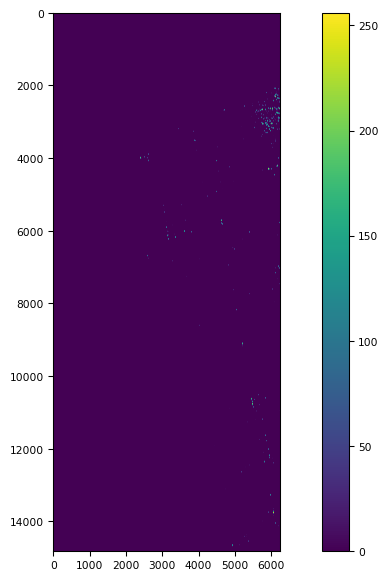

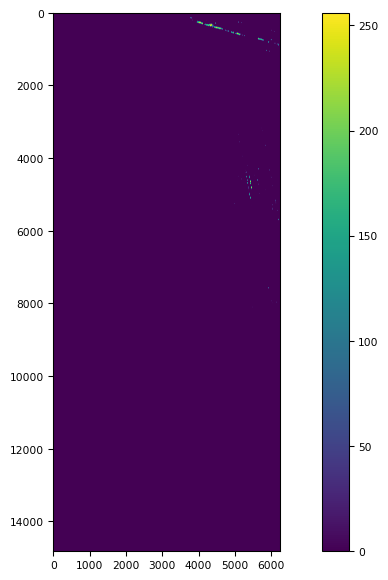

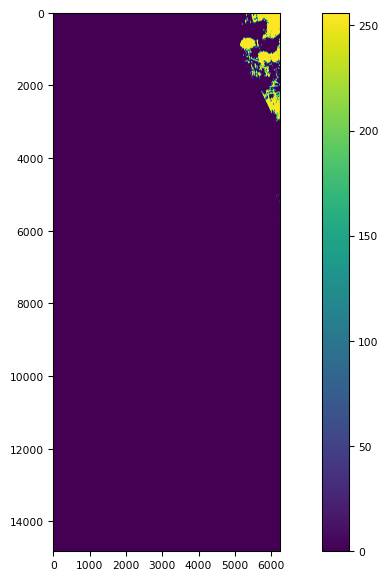

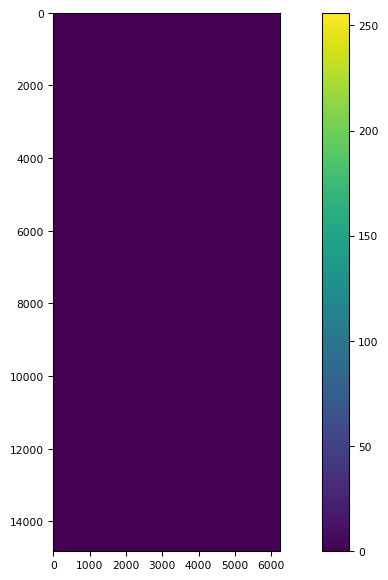

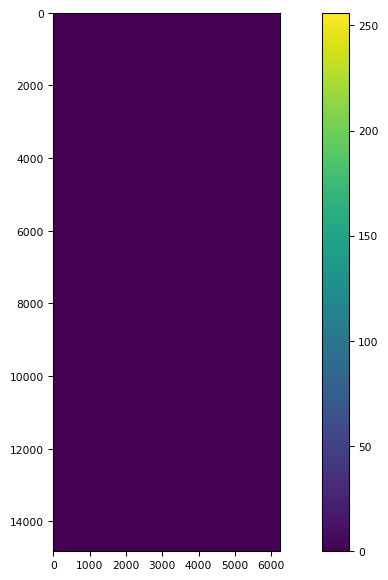

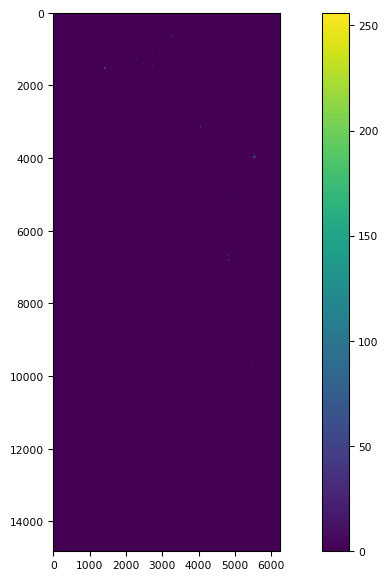

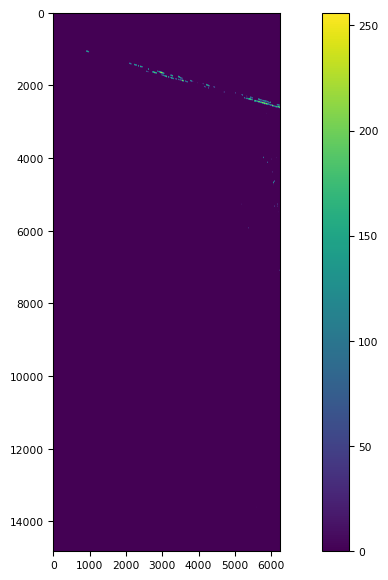

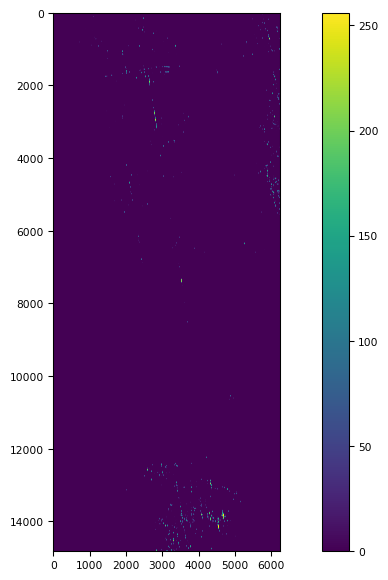

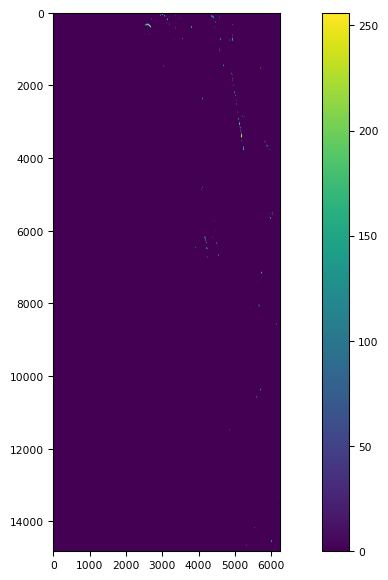

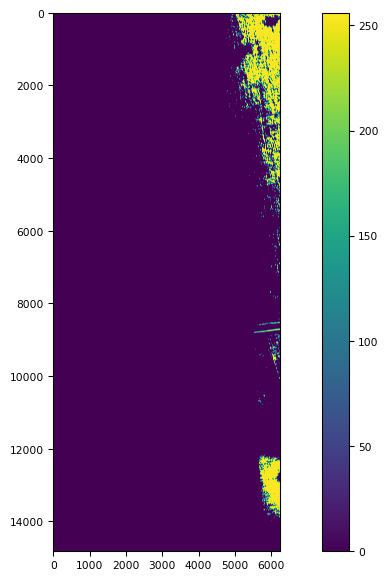

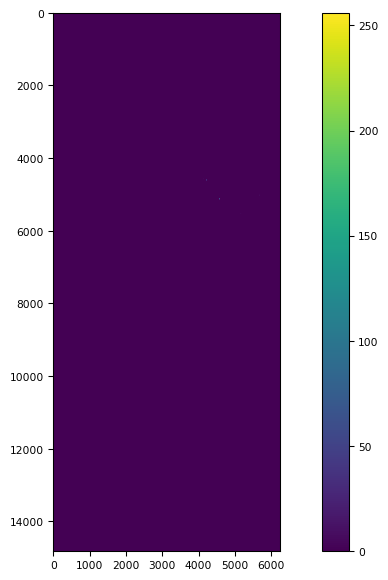

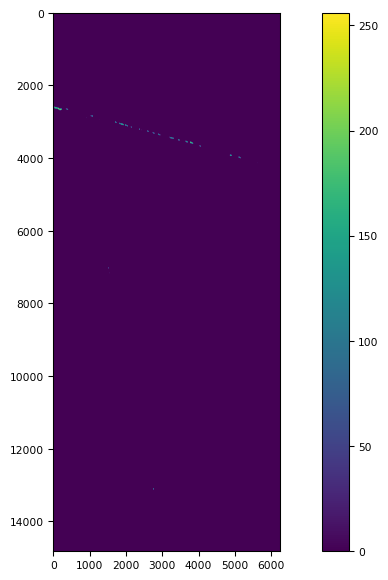

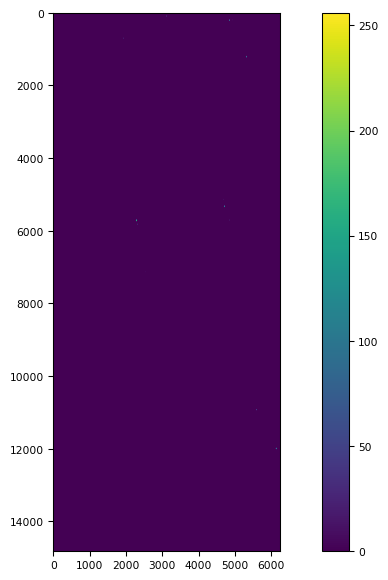

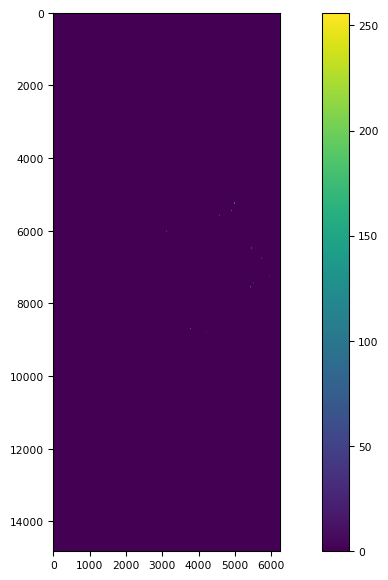

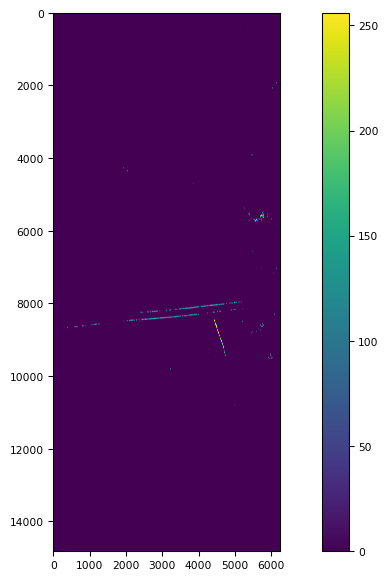

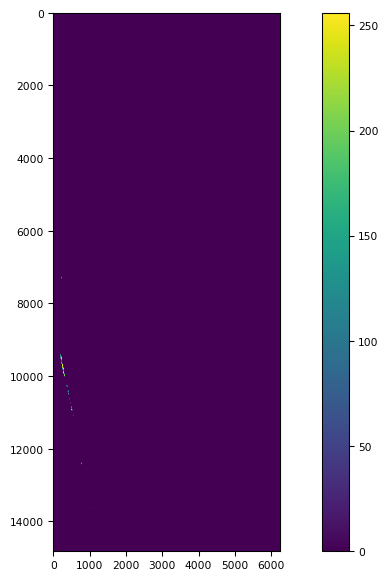

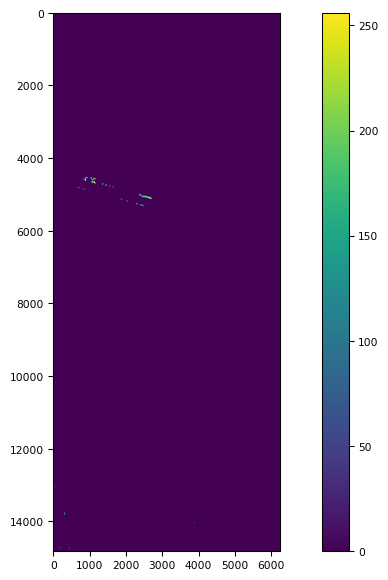

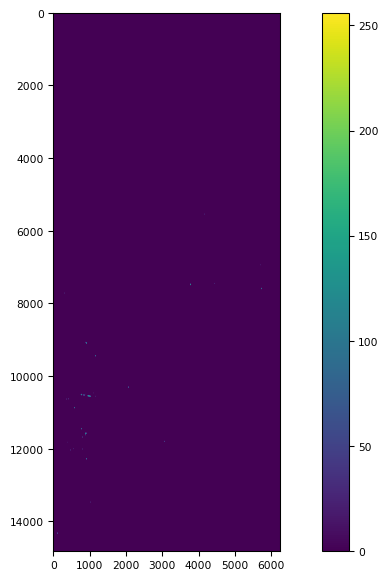

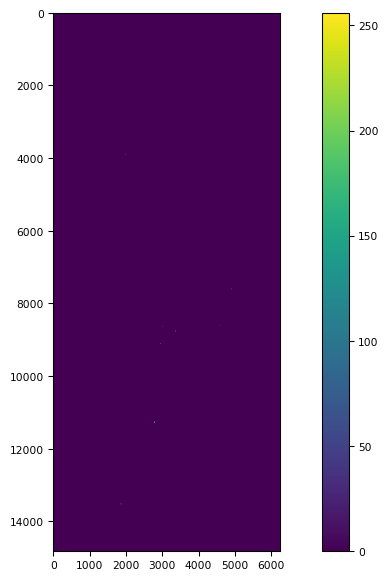

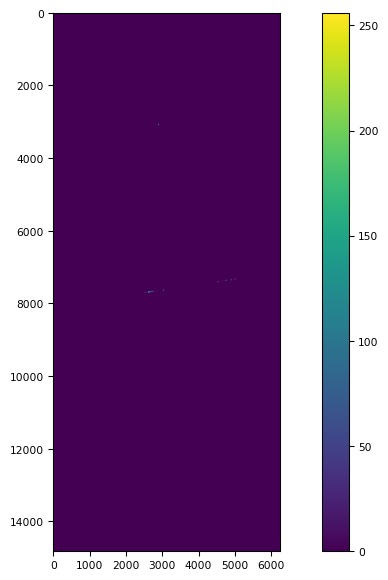

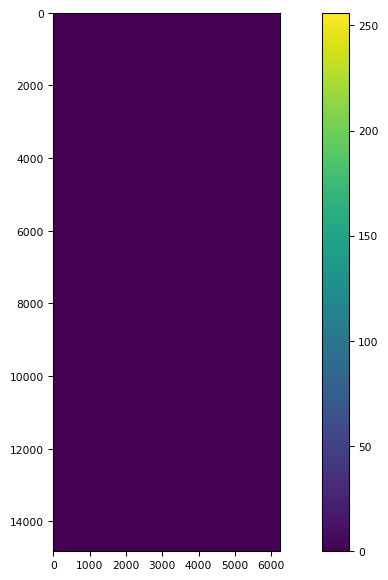

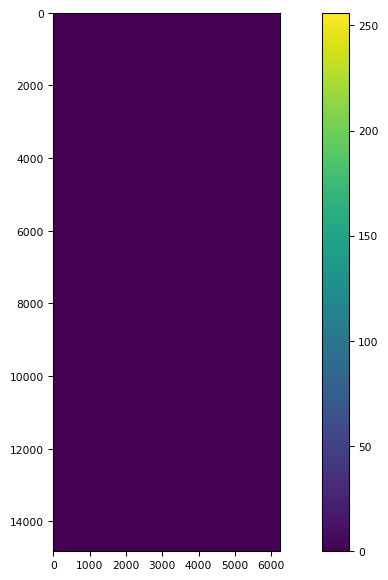

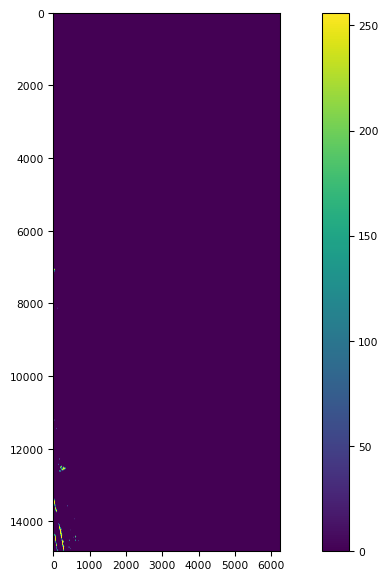

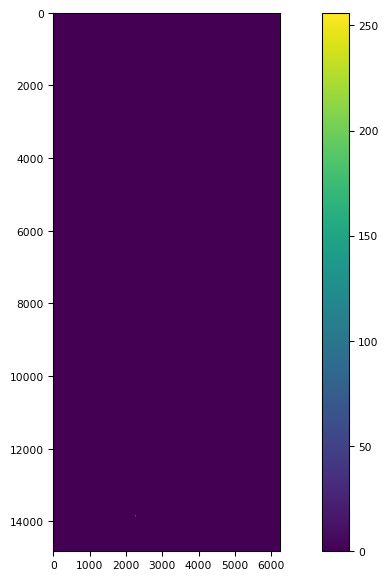

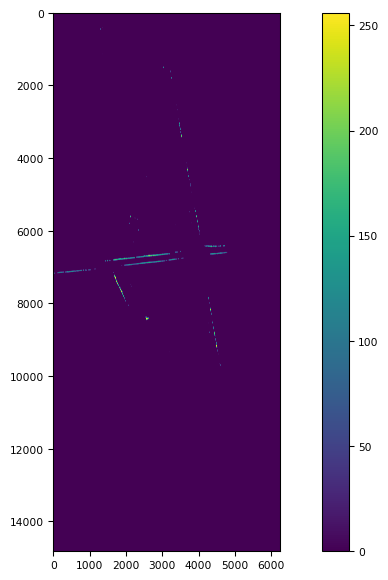

In [31]:
load_preprocess_locate_crop_extreme(thm_path=thm_path, thm_file_names=east_thm_file_names, rgb_path=rgb_path, rgb_file_names=east_rgb_file_names, roi_path=roi_path,
                                    GaussianBlurRadius=21, boundingRect_w_limit=10, boundingRect_h_limit=10, boundingRect_k_padding=20)